In [1]:
import os
from pathlib import Path


os.chdir(Path.cwd().parent)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from src.optimizers.step_controllers.step_controllers import (
    StepControllerBase, ConstantController, BacktrackingLineSearchController
)
from src.optimizers.riemannian_trust_region import RiemannianTrustRegionMethod
from src.optimizers.jacobi_davidson import JDIteration
from src.optimizers.utils.report import basic_report
from src.rayleigh_quotient import rayleigh_quotient
from src.utils.linalg import (
    generate_normalized_vector, generate_supersymmetric_tensor, tenvec
)


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def test_jacobi_davidson_method_base(
    A: np.ndarray,
    x: np.ndarray,
    step_controllers: list[StepControllerBase] = [ConstantController(), BacktrackingLineSearchController()],
    *,
    plot: bool = False,
    show_label: bool = False,
    verbose: bool = False) -> None:
    """
    Ensures Jacobi-Davidson method for f(x) = R_A(X) converges to eigenpair.

    :param A: supersymmetric tensor of shape (n x n x ... x n) of order k
    :param x: normalized vector of shape (n,)
    :paran step_controllers: step controllers to use.
        Default is to use all implemented with default parameters
    :param plot: whether to plot statistics
    :param show_label: whether to show label(name) of step controller when plotting
    :param verbose: whether to print more info
    """
    if verbose:
        print(f"testing Jacobi-Davidson method with parameters:\n"
              f"tensor A of shape {A.shape}\nA = {A}\n"
              f"vector x = {x}")
    k = A.ndim
    method = JDIteration(A, eigsolver=RiemannianTrustRegionMethod, eigsolver_params={"invalid": "fix"})
    step_controllers = [ConstantController(), BacktrackingLineSearchController()]

    if plot:
        fig, axs = plt.subplots(3, 2, figsize=(12, 12))
        fig.suptitle(f"Jacobi-Davidson method statistics for tensor of shape {A.shape}", fontsize=18)

        axs[0, 0].set(title="Rayleigh quotient values")
        axs[0, 1].set(title="Rayleigh quotient residual values log scaled")
        axs[1, 0].set(title="Rayleigh quotient gradient norm values log scaled")
        axs[1, 1].set(title="Rayleigh quotient gradient residual norm values log scaled")
        axs[2, 0].set(title="Rayleigh quotient values on intermediate eigsolver iterations")
        axs[2, 1].set(title="Steps on intermediate eigsolver iterations")

    success_all = True
    for step_controller in step_controllers:
        name = step_controller.name()
        x_eign = method.minimize(x.reshape(-1, 1), step_controller=step_controller)
        rq_eign = rayleigh_quotient(A, x_eign)

        x_expected = rq_eign * x_eign
        x_computed = tenvec(A, x_eign, times=k-1)

        success = np.allclose(x_expected, x_computed, atol=1e-4)
        if success:
            if plot:
                f_hist, f_residual_hist, f_grad_norm_hist, f_grad_residual_norm_hist = basic_report(method.rq, method.rq_grad, method._x_top_history)
                f_hist_all, f_residual_hist_all, f_grad_norm_hist_all, f_grad_residual_norm_hist_all = basic_report(method.rq, method.rq_grad, method._x_history)
                yscales = np.array([
                    ['linear', 'log'],
                    ['log', 'log'],
                    ['linear', 'linear']
                ])
                for i, stat in enumerate([
                    f_hist, f_residual_hist,
                    f_grad_norm_hist, f_grad_residual_norm_hist,
                    f_hist_all, method._step_history
                    ]):
                    idx = np.unravel_index(i, (3, 2))
                    axs[idx].plot(range(len(stat)), stat, label=name)
                    axs[idx].set_yscale(yscales[idx])
                    axs[idx].grid(True)
                    if show_label:
                        axs[idx].legend()

                fig.tight_layout()

        else:
            print(f"Jacobi-Davidson method with {name} step controller failed", file=sys.stderr)
            success_all = False
    assert success_all


In [5]:
def test_jacobi_davidson_method_simple() -> None:
    n = 2
    k = 2
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_jacobi_davidson_method_base(a, x, plot=True, show_label=True)

def test_jacobi_davidson_method_medium() -> None:
    n = 3
    k = 3
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_jacobi_davidson_method_base(a, x, plot=True, show_label=True)

def test_jacobi_davidson_method_hard() -> None:
    n = 6
    k = 6
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_jacobi_davidson_method_base(a, x, plot=True, show_label=True)

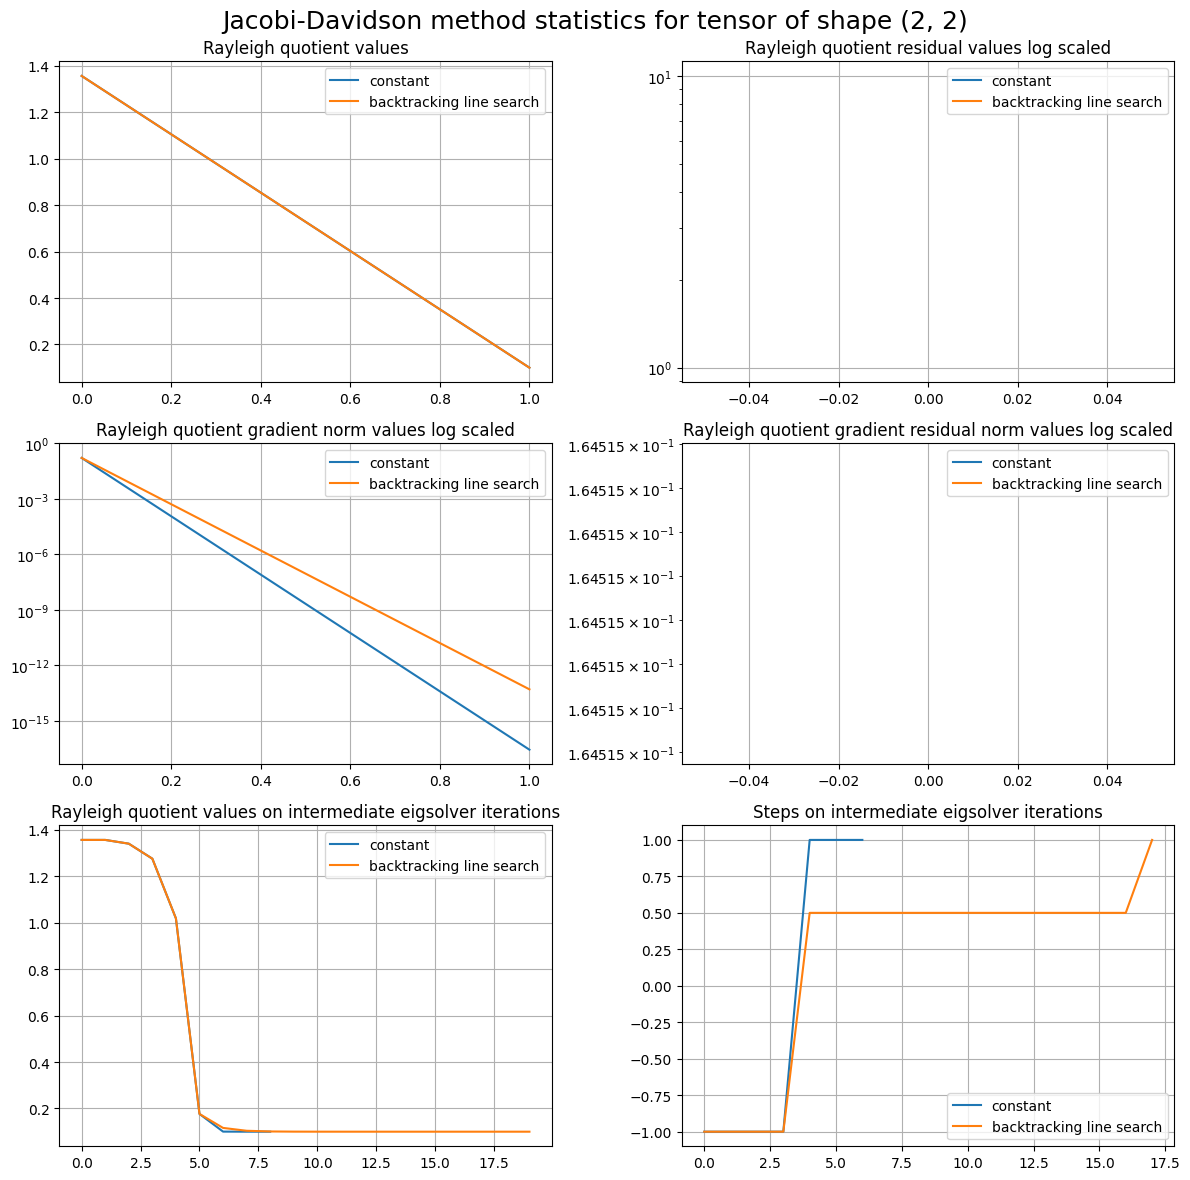

In [6]:
test_jacobi_davidson_method_simple()

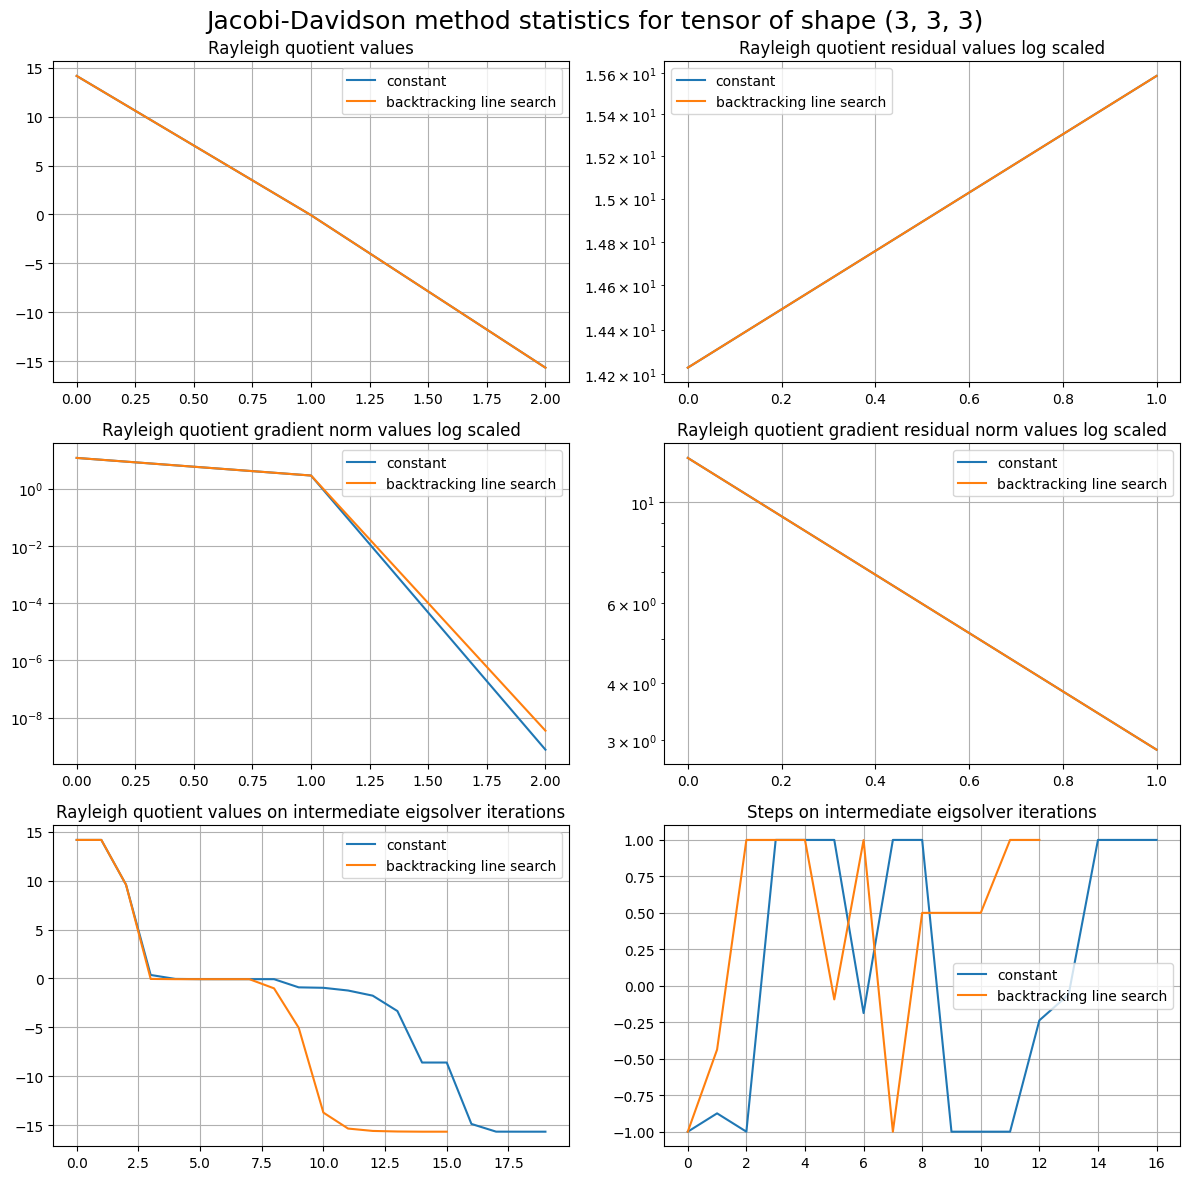

In [7]:
test_jacobi_davidson_method_medium()

/home/chep0k/hse/3-course/jdm/src/optimizers/riemannian_trust_region.py:60: UserWarning: max iterations reached
  warnings.warn("max iterations reached")
/home/chep0k/hse/3-course/jdm/src/optimizers/jacobi_davidson.py:110: UserWarning: |V| is no more orthonormal. It has more columns than rows
  warnings.warn("|V| is no more orthonormal. It has more columns than rows")
Jacobi-Davidson method with constant step controller failed


AssertionError: 

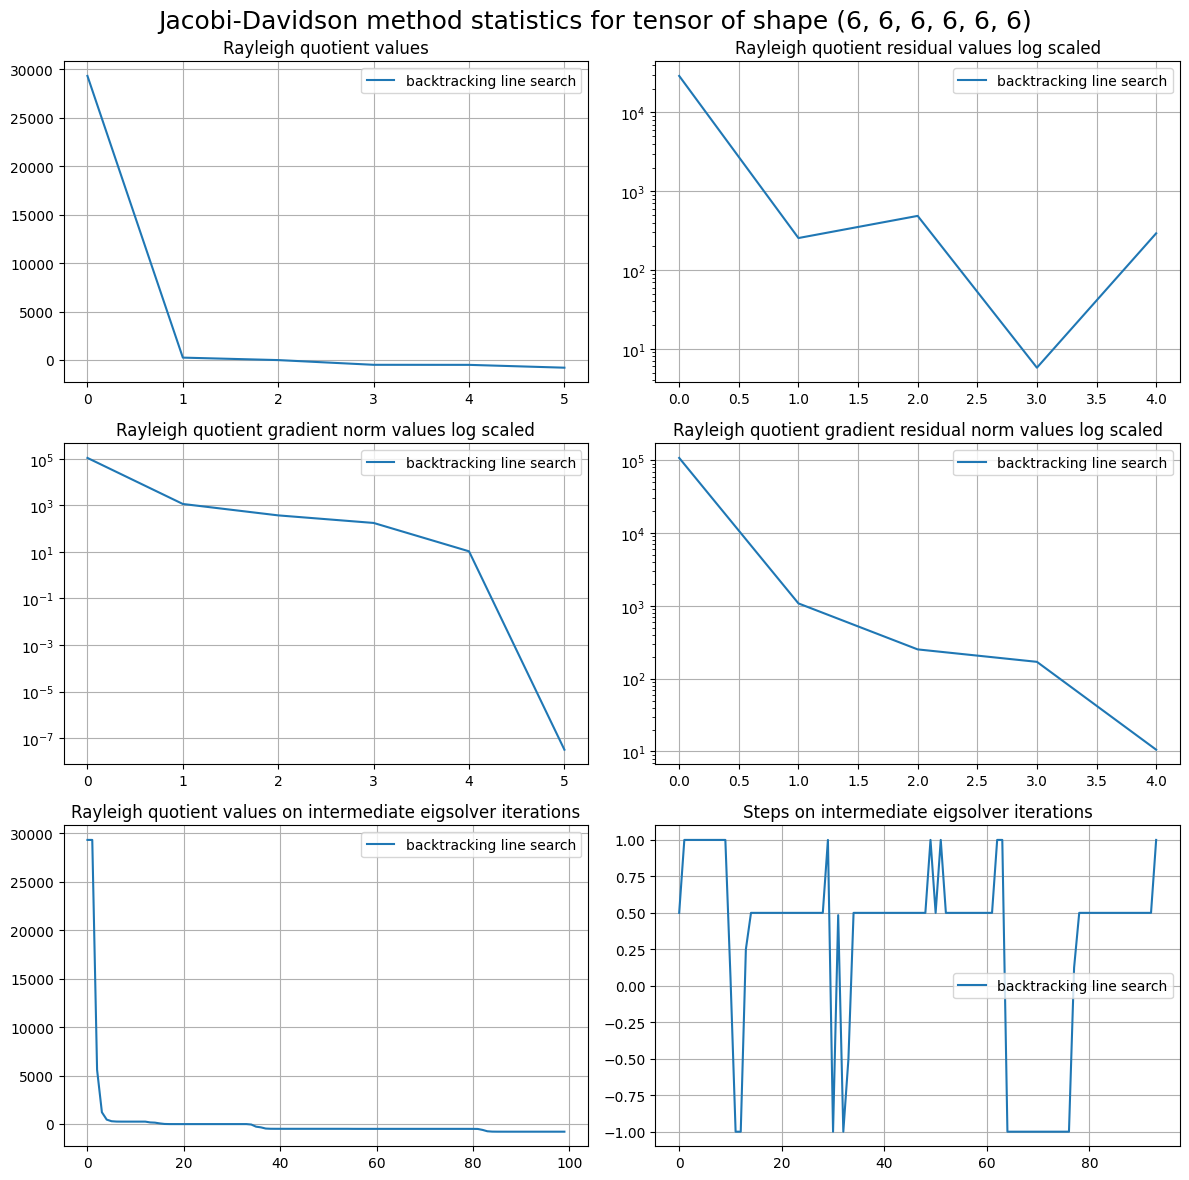

In [8]:
test_jacobi_davidson_method_hard()